In [145]:
import numpy as np # álgebra linear
import pandas as pd # processamento de informações, arquivo CSV
import matplotlib.pyplot as plt # plotagem de gráficos
import seaborn as sns # plotagem interativa de gráficos
%matplotlib inline
from sklearn.linear_model import LogisticRegression # para aplicar regressão logística
from sklearn.cross_validation import KFold # para uso de cross validation
from sklearn.model_selection import GridSearchCV, cross_val_score # para ajuste de parâmetros
from sklearn.ensemble import RandomForestClassifier # para aplicar a classificação por floresta aleatória
from sklearn.naive_bayes import GaussianNB # para aplicar classificação bayesiana
from sklearn.neighbors import KNeighborsClassifier # para aplicar knn
from sklearn.tree import DecisionTreeClassifier # para aplicar árvores de decisão
from sklearn import svm # para aplicar a svm
from sklearn import metrics # para checar o erro e a acurácia do modelo
from sklearn.model_selection import train_test_split # para dividir os dados em duas partes
import time

### Importando dados do arquivo csv

In [146]:
data = pd.read_csv("data.csv", header = 0) # header = 0 indica que a linha 0 contém os nomes das colunas

### Analisando os dados presentes

In [147]:
print(data.head(2)) # Imprimindo apenas as duas primeiras linhas

       id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0  842302         M        17.99         10.38           122.8     1001.0   
1  842517         M        20.57         17.77           132.9     1326.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   

      ...       texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0     ...               17.33            184.6      2019.0            0.1622   
1     ...               23.41            158.8      1956.0            0.1238   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   

   fractal_dimension_worst  Unnamed: 32  
0              

In [148]:
data.info() # verificando os tipos dos dados e algumas informações

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
id                         569 non-null int64
diagnosis                  569 non-null object
radius_mean                569 non-null float64
texture_mean               569 non-null float64
perimeter_mean             569 non-null float64
area_mean                  569 non-null float64
smoothness_mean            569 non-null float64
compactness_mean           569 non-null float64
concavity_mean             569 non-null float64
concave points_mean        569 non-null float64
symmetry_mean              569 non-null float64
fractal_dimension_mean     569 non-null float64
radius_se                  569 non-null float64
texture_se                 569 non-null float64
perimeter_se               569 non-null float64
area_se                    569 non-null float64
smoothness_se              569 non-null float64
compactness_se             569 non-null float64
concavity_se               569 non

#### Descrevendo as informações mostradas temos que a coluna *area_mean*, por exemplo, tem 569 valores (um para cada instância) não nulos e do tipo float64.  

#### Pode-se observar a presença de uma coluna chamada _Unnamed: 32_ que em todas as linhas não apresenta valores, portanto, iremos retirá-la. A coluna _id_ também será retirada pois não será relevante.

In [149]:
data.drop("Unnamed: 32", axis = 1, inplace = True) # axis = 1 informa a exclusão de uma coluna e inplace = True informa 
                                                   # que não é necessário salvar os dados originais
data.drop("id", axis = 1, inplace = True)
    
data.columns # imprime as colunas, nota-se que Unnamed: 32 e id não se encontram presente

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

#### Os atributos podem ser divididos em 3 partes, pois cada um deles possui três categorias: média, erro padrão e pior caso.

In [150]:
features_mean = list(data.columns[1:11]) # dividindo por categoria
features_se = list(data.columns[11:21])
features_worst = list(data.columns[21:31])

print(features_mean)
print("-----------------------------------------------------------------------------------------------------------------")
print(features_se)
print("-----------------------------------------------------------------------------------------------------------------")
print(features_worst)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
-----------------------------------------------------------------------------------------------------------------
['radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']
-----------------------------------------------------------------------------------------------------------------
['radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']


#### Mapearemos os valores da coluna _diagnosis_ para valores binários. M(Maligno): para 1. B(Benigno) para 0.



In [151]:
data['diagnosis'] = data['diagnosis'].map({'M':1,'B':0})

## Explorando os dados

In [152]:
data.describe() # descreve funções estatísticas dos dados 

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### Analisando a quantidade de casos benignos e malignos no dataset por meio de um gráfico temos: 

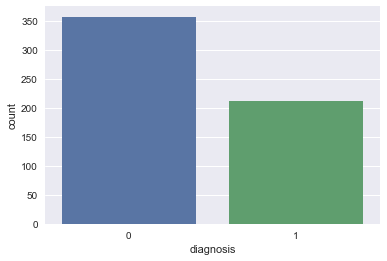

In [153]:
sns.countplot(data['diagnosis'], label = "Quantidade") # obtem a frequência dos estágios de câncer

#### Portanto, observamos que a quantidade de casos de câncer benigno, ou seja com possibilidade de cura, é maior.

## Analisando os atributos

#### Iremos agora selecionar os atributos categorizados como média (features_mean) que são mais interessantes para fazerem parte do treinamento e dos testes, estes são chamados de nucleus features. Para tal, realizaremos o plot de um scatter plot e de um histograma para a partir deles identificarmos os atributos que são capazes de estabelecer um limite/plano separável para as duas classes de câncer. 

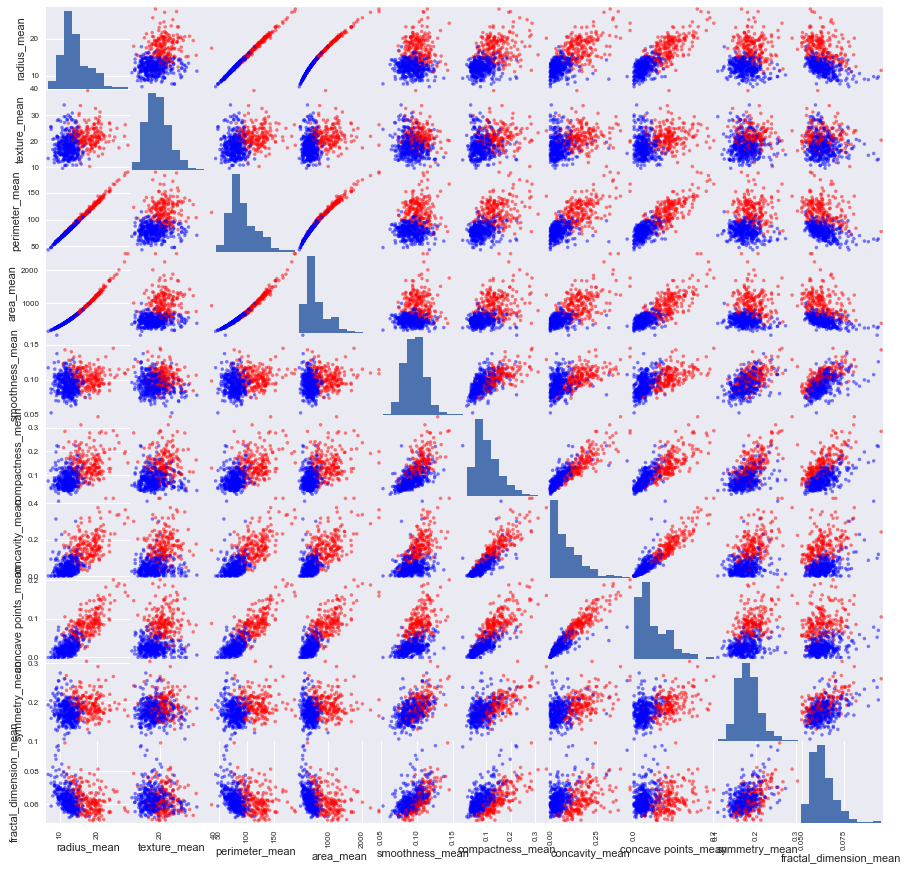

In [154]:
colors_dic = {0:'blue', 1:'red'} # pontos de cor azul representam objetos (câncers) diagnosticados como benignos e os
                                 # vermelhos malignos
colors = data['diagnosis'].map(lambda num:colors_dic.get(num)) # mapeando colors_dic com os valores da coluna diagnosis 
pd.plotting.scatter_matrix(data[features_mean], c = colors, alpha = 0.5, figsize = (15,15)); #plotando scatter plot matrix

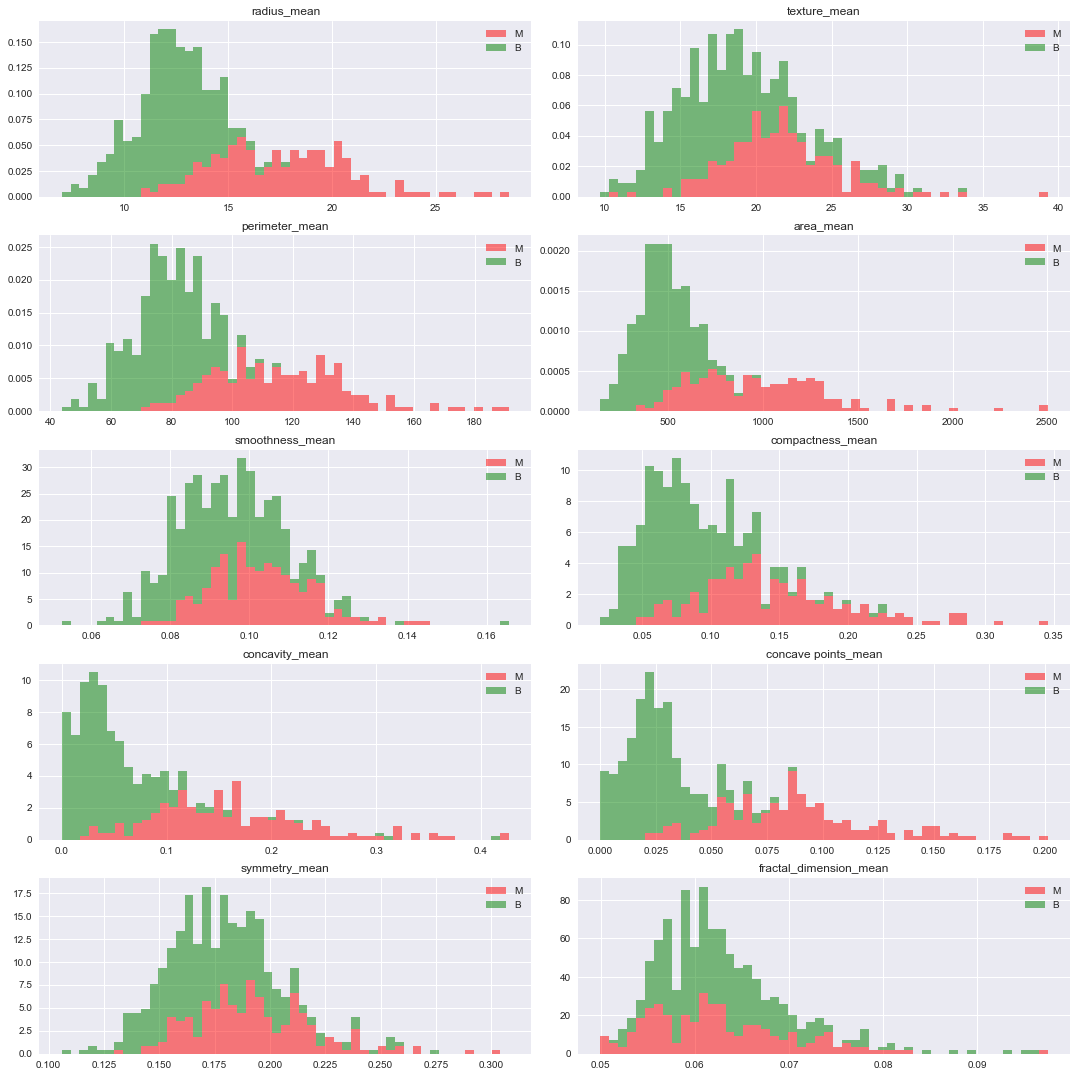

In [155]:
# dividindo dataset em dois, de acordo com o diagnóstico
dM=data[data['diagnosis'] ==1]
dB=data[data['diagnosis'] ==0]
# empilhando os dados
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15,15))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(data[features_mean[idx]]) - min(data[features_mean[idx]]))/50
    ax.hist([dM[features_mean[idx]],dB[features_mean[idx]]], bins=np.arange(min(data[features_mean[idx]]), max(data[features_mean[idx]]) + binwidth, binwidth) , alpha=0.5,stacked=True, normed = True, label=['M','B'],color=['r','g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

#### Observações:

 * Os atributos *radius_mean, perimeter_mean, area_mean, compactness_mean, concavity_mean* e *concave points_mean* podem ser usados para classificação do tipo de câncer. Valores maiores desses parâmetros tendem a mostrar uma correlação ao tipo maligno.
 * Os valores dos atributos *texture_mean, smoothness_mean, symmetry_mean* e *fractal_dimension_mean* não demonstram uma preferência particular de um diagnóstico em relação ao outro.

#### Baseando-se nessas observações, podemos assumir que a classificação do tumor depende dos seguintes atributos/variáveis:

In [156]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concavity_mean','concave points_mean']

## Criando conjunto de teste e de treinamento

#### Dividiremos agora o dataset. 30% do mesmo será destinado ao processo de teste e 70% ao treinamento.

In [157]:
train_data, test_data = train_test_split(data, test_size = 0.3) # função da biblioteca sklearn

print(train_data.shape) # imprime a quantidade de linhas e de colunas dos dados de treinamento
print(test_data.shape) # imprime a quantidade de linhas e de colunas dos dados de teste

(398, 31)
(171, 31)


## Modelo de Classificação

#### Iremos implementar um modelo de classificação genérico e avaliar seu desempenho usando o conjunto de treinamento. Usaremos a técnica de cross validation e realizaremos ajustes de parâmetros usando a função GridSearchCV() que faz uma pesquisa exaustiva sobre os valores de parêmetros indicados procurando pela melhor combinação dos mesmos de modo que promova maior acurácia. 

In [158]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.cross_validation import KFold

def classification_model(model, train_data, test_data, predictors, outcome):
  model.fit(train_data[predictors],train_data[outcome])  # ajuste de parâmetros do modelo
  
  predictions = model.predict(test_data[predictors])  # obtendo resultados de predição

  accuracy = metrics.accuracy_score(predictions,test_data[outcome])  # cálculo da acurácia a partir dos resultados obtidos
  print("Accuracy : %s" % "{0:.3%}".format(accuracy))                # e dos desejados

  kf = KFold(data.shape[0], n_folds=5)  # cross-validation
  scores = cross_val_score(model, data[predictors], data[outcome], cv=5)  # resultados obtidos utilizando cross-validation
  for i in range(0,5):
    print("Cross-Validation Score : %s" % "{0:.3%}".format(scores[i]))
  print("Cross-Validation Mean Score : %s" % "{0:.3%}".format(np.mean(scores)))
  
  # Ajuste do modelo novamente para o caso de ser usado posteriormente
  model.fit(train_data[predictors],train_data[outcome])

## Regressão Logística

#### A Regressão Logística é bastante usada para classificação de dados discretos. Neste caso, ela será usada para classificar no formato binário (0 ou 1). Primeiro utilizaremos todos os atributos:

In [159]:
from sklearn.linear_model import LogisticRegression

predictor_var = features_mean
outcome_var='diagnosis'
model = LogisticRegression()
classification_model(model,train_data,test_data,predictor_var,outcome_var)

Accuracy : 91.228%
Cross-Validation Score : 86.957%
Cross-Validation Score : 88.696%
Cross-Validation Score : 90.265%
Cross-Validation Score : 93.805%
Cross-Validation Score : 92.035%
Cross-Validation Mean Score : 90.352%


#### Agora com os atributos selecionados:

In [160]:
from sklearn.linear_model import LogisticRegression

predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
outcome_var='diagnosis'
model=LogisticRegression()
classification_model(model,train_data,test_data,predictor_var,outcome_var)

Accuracy : 89.474%
Cross-Validation Score : 83.478%
Cross-Validation Score : 88.696%
Cross-Validation Score : 90.265%
Cross-Validation Score : 92.920%
Cross-Validation Score : 91.150%
Cross-Validation Mean Score : 89.302%


#### Em ambos os casos acurácia do modelo é boa mas, não é ótima. Em relação às pontuações de cross-validation podemos inferir o mesmo. Vamos testar com outro modelo...

## Árvore de decisão

#### É uma das formas de algoritmo de aprendizado mais simples e de maior sucesso. Tem como entrada um objeto ou situação descritos por um conjunto de atributos e como saída uma “decisão” (previsão do valor de saída dada a entrada). Uma árvore de decisão toma as suas decisões através de uma sequência de testes. Primeiros utilizaremos todos os atributos:

In [161]:
from sklearn.tree import DecisionTreeClassifier

predictor_var = features_mean
outcome_var='diagnosis'
model = DecisionTreeClassifier()
classification_model(model,train_data,test_data,predictor_var,outcome_var)

Accuracy : 90.058%
Cross-Validation Score : 87.826%
Cross-Validation Score : 89.565%
Cross-Validation Score : 88.496%
Cross-Validation Score : 93.805%
Cross-Validation Score : 93.805%
Cross-Validation Mean Score : 90.699%


#### Agora com os atributos selecionados:

In [162]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
outcome_var='diagnosis'
model = DecisionTreeClassifier()
classification_model(model,train_data,test_data,predictor_var,outcome_var)

Accuracy : 87.719%
Cross-Validation Score : 86.087%
Cross-Validation Score : 86.087%
Cross-Validation Score : 90.265%
Cross-Validation Score : 92.920%
Cross-Validation Score : 90.265%
Cross-Validation Mean Score : 89.125%


#### Neste modelo, ao usarmos todos os atributos temos resultados superiores em relação aos de regressão logística.

## KNN

#### É um dos algoritmos de classificação mais simples e é usado para classificar objetos com base em exemplos de treinamento que estão mais próximos no espaço de características. 

In [163]:
from sklearn.neighbors import KNeighborsClassifier

predictor_var = features_mean
model = KNeighborsClassifier()
classification_model(model,train_data,test_data,predictor_var,outcome_var)

Accuracy : 86.550%
Cross-Validation Score : 85.217%
Cross-Validation Score : 85.217%
Cross-Validation Score : 88.496%
Cross-Validation Score : 94.690%
Cross-Validation Score : 89.381%
Cross-Validation Mean Score : 88.600%


#### Usando atributos selecionados, temos:

In [164]:
from sklearn.neighbors import KNeighborsClassifier

predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
outcome_var='diagnosis'
model = KNeighborsClassifier()
classification_model(model,train_data,test_data,predictor_var,outcome_var)

Accuracy : 85.965%
Cross-Validation Score : 83.478%
Cross-Validation Score : 86.087%
Cross-Validation Score : 88.496%
Cross-Validation Score : 93.805%
Cross-Validation Score : 89.381%
Cross-Validation Mean Score : 88.249%


## Random Forest

#### Inicialmente iremos fazer diferente. Iremos usar o Random Forest com todos os atributos do dataset e não somente com atributos selecionados. A razão disso é que ele possui a vantagem de retornar uma matriz com a importância de cada feature. Desta forma podemos selecionar os melhores para fazerem parte do treinamento e refazer o modelo. Posteriormente podemos comparar a diferença de desempenho de acordo com os atributos envolvidos. 

#### Usando todos os atributos, temos: 

In [165]:
from sklearn.ensemble import RandomForestClassifier

predictor_var = features_mean
outcome_var='diagnosis'
model = RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, train_data,test_data,predictor_var,outcome_var)

Accuracy : 92.982%
Cross-Validation Score : 89.565%
Cross-Validation Score : 93.043%
Cross-Validation Score : 94.690%
Cross-Validation Score : 96.460%
Cross-Validation Score : 93.805%
Cross-Validation Mean Score : 93.513%


#### Usando atributos selecionados, temos:

In [166]:
from sklearn.ensemble import RandomForestClassifier

predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
outcome_var='diagnosis'
model = RandomForestClassifier(n_estimators=100,min_samples_split=25, max_depth=7, max_features=2)
classification_model(model, train_data,test_data,predictor_var,outcome_var)

Accuracy : 90.643%
Cross-Validation Score : 86.957%
Cross-Validation Score : 93.043%
Cross-Validation Score : 93.805%
Cross-Validation Score : 94.690%
Cross-Validation Score : 91.150%
Cross-Validation Mean Score : 91.929%


#### Temos que o Random Forest apresenta bons resultados usando atributos selecionados e ótimos usando todos os atributos do dateset. 

#### Exploraremos agora uma grande vantagem que esse método de classificação possui que é o fato de que o mesmo nos retorna uma matriz com a importância de cada atributo. A partir dessa informação identificaremos os atributos mais relevantes para o nosso problema.

In [167]:
featimp = pd.Series(model.feature_importances_, index=predictor_var).sort_values(ascending=False)
print(featimp)

concave points_mean    0.265203
area_mean              0.228196
concave points_mean    0.207304
perimeter_mean         0.170214
radius_mean            0.108374
compactness_mean       0.020709
dtype: float64


#### Sabemos agora que os 6 atributos de maior relevância são: *concave_points_mean, perimeter_mean, concavity_mean,  area_mean* e *compactness_mean*. Podemos dizer então que a análise dos atributos importantes, a partir dos gráficos, que fizemos anteriormente está correta.

#### A título de curiosidade, como seriam os resultados caso utilizássemos somente o atributo mais relevante?

In [168]:
from sklearn.ensemble import RandomForestClassifier

predictor_var =  ['concave points_mean']
model = RandomForestClassifier(n_estimators=100)
classification_model(model, train_data,test_data,predictor_var,outcome_var)

Accuracy : 83.626%
Cross-Validation Score : 80.870%
Cross-Validation Score : 89.565%
Cross-Validation Score : 84.956%
Cross-Validation Score : 86.726%
Cross-Validation Score : 85.841%
Cross-Validation Mean Score : 85.591%


#### Como esperado, temos valores de acurácia e cross-validation não muito satisfatórios.

## SVM

#### Método de classificação para dados lineares e não-lineanes, sempre separa duas classes por meio de um hiperplano com a maior distância entre as classes. Encontra o hiperplano usando vetores suportes (tuplas especiais no treinamento) e margens definidas pelos vetores suportes.

#### Com todos os atributos:

In [169]:
from sklearn import svm

predictor_var = features_mean
model = svm.SVC(kernel='linear', C=1)
classification_model(model, train_data,test_data,predictor_var,outcome_var)

Accuracy : 92.398%
Cross-Validation Score : 86.087%
Cross-Validation Score : 88.696%
Cross-Validation Score : 92.920%
Cross-Validation Score : 92.920%
Cross-Validation Score : 92.920%
Cross-Validation Mean Score : 90.709%


#### Com os selecionados:

In [170]:
from sklearn import svm

predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
model = svm.SVC(kernel='linear', C=1)
classification_model(model, train_data,test_data,predictor_var,outcome_var)

Accuracy : 89.474%
Cross-Validation Score : 83.478%
Cross-Validation Score : 88.696%
Cross-Validation Score : 90.265%
Cross-Validation Score : 92.920%
Cross-Validation Score : 92.035%
Cross-Validation Mean Score : 89.479%


### Podemos observar que para este problema a seleção dos atributos mais significativos e relevantes não implica necessariamente na melhora da acurária dos métodos, o que pode não acontecer em problemas de naturezas e dados diferentes. 

# Ajustando parâmetros usando grid search CV

#### Até então usamos valores de parâmetros que são considerados adequados para um bom desempenho, porém, podemos descobrir se é possível obter melhores resultados usando a melhor combinação de valores para esses parâmetros aplicando-os ao modelo.  Para tal, utilizaremos gripsearchCV em um novo modelo de classificação.

## Novo Modelo de Classificação

#### Neste novo modelo estaremos ainda calculando a pontuação por cross-validation de cada método, porém, usando a função _GridSearchCV()_ para encontrar os melhores parâmetros. A marcação de tempo também é feita para que ele seja levado em consideração como métrica. 

In [299]:
from sklearn.model_selection import GridSearchCV
import time

def Classification_model_gridsearchCV(model, param_grid, data_X, data_y):
    start_time = time.time()
    # busca pela combinação de parâmetros que possui maior acurácia utilizando cross-validation
    clf = GridSearchCV(model,param_grid,cv=10,scoring="accuracy")
    clf.fit(data_X,data_y)  # ajuste do modelo com os parâmetros encontrados
    
    method_score = clf.best_score_*100
    processing_time = time.time() - start_time
    
    print("Melhor combinação de parâmetros encontrada:")
    print(clf.best_params_)
    print()
    print("Cross-validation score proporcionada por essa combinação de parâmetros: %s" %"{0:.3f}%".format(method_score))
    print("Processing time: %s seconds" % (processing_time))
    
    return method_score, processing_time
    

#### Iremos guardar as pontuações e os tempos para análises futuras. 

In [323]:
all_scores = []
all_times = []

## Regressão Logística

#### Utilizando todos os atributos:

In [301]:
predictor_var = features_mean
outcome_var ='diagnosis'
data_X = data[predictor_var] # input data
data_y = data["diagnosis"] # output data

In [324]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }  # valores de parâmetros a serem testados
model = LogisticRegression()
sc,tm = Classification_model_gridsearchCV(model,param_grid,data_X,data_y)
all_scores.append(sc)
all_times.append(tm)

Melhor combinação de parâmetros encontrada:
{'C': 100}

Cross-validation score proporcionada por essa combinação de parâmetros: 90.861%
Processing time: 0.36811065673828125 seconds


#### Atributos selecionados:

In [303]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
outcome_var='diagnosis'
data_X= data[predictor_var] # input data
data_y= data["diagnosis"] # output data

In [304]:
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }  # valores de parâmetros a serem testados
model = LogisticRegression()
Classification_model_gridsearchCV(model,param_grid,data_X,data_y)

Melhor combinação de parâmetros encontrada:
{'C': 100}

Cross-validation score proporcionada por essa combinação de parâmetros: 90.861%
Processing time: 0.3685917854309082 seconds


## Árvore de Decisão

#### Utilizando todos os atributos:

In [305]:
predictor_var = features_mean
outcome_var='diagnosis'
data_X= data[predictor_var] # input data
data_y= data["diagnosis"] # output data

In [325]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],  # valores de parâmetros a serem testados
              'min_samples_split': [2,3,4,5,6,7,8,9,10], 
              'min_samples_leaf':[2,3,4,5,6,7,8,9,10] }
model= DecisionTreeClassifier()
sc,tm = Classification_model_gridsearchCV(model,param_grid,data_X,data_y)
all_scores.append(sc)
all_times.append(tm)

Melhor combinação de parâmetros encontrada:
{'max_features': 'log2', 'min_samples_leaf': 7, 'min_samples_split': 9}

Cross-validation score proporcionada por essa combinação de parâmetros: 92.091%
Processing time: 8.015990972518921 seconds


#### Atributos selecionados: 

In [307]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
outcome_var='diagnosis'
data_X= data[predictor_var] # input data
data_y= data["diagnosis"] # output data

In [308]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],  # valores de parâmetros a serem testados
              'min_samples_split': [2,3,4,5,6,7,8,9,10], 
              'min_samples_leaf':[2,3,4,5,6,7,8,9,10] }
model= DecisionTreeClassifier()
Classification_model_gridsearchCV(model,param_grid,data_X,data_y)

Melhor combinação de parâmetros encontrada:
{'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 2}

Cross-validation score proporcionada por essa combinação de parâmetros: 91.388%
Processing time: 7.469842433929443 seconds


## KNN

#### Utilizando todos os atributos:

In [309]:
predictor_var = features_mean
outcome_var='diagnosis'
data_X= data[predictor_var] # input data
data_y= data["diagnosis"] # output data

In [326]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

k_range = list(range(1, 30))  # valores de parâmetros a serem testados
leaf_size = list(range(1,30))
weight_options = ['uniform', 'distance']
param_grid = {'n_neighbors': k_range, 'leaf_size': leaf_size, 'weights': weight_options}
sc,tm = Classification_model_gridsearchCV(model,param_grid,data_X,data_y)
all_scores.append(sc)
all_times.append(tm)

Melhor combinação de parâmetros encontrada:
{'leaf_size': 1, 'n_neighbors': 19, 'weights': 'uniform'}

Cross-validation score proporcionada por essa combinação de parâmetros: 89.455%
Processing time: 108.4723162651062 seconds


#### Atributos selecionados: 

In [311]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
outcome_var='diagnosis'
data_X= data[predictor_var] # input data
data_y= data["diagnosis"] # output data

In [312]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

k_range = list(range(1, 30))  # valores de parâmetros a serem testados
leaf_size = list(range(1,30))
weight_options = ['uniform', 'distance']
param_grid = {'n_neighbors': k_range, 'leaf_size': leaf_size, 'weights': weight_options}
Classification_model_gridsearchCV(model,param_grid,data_X,data_y)

Melhor combinação de parâmetros encontrada:
{'leaf_size': 1, 'n_neighbors': 19, 'weights': 'uniform'}

Cross-validation score proporcionada por essa combinação de parâmetros: 89.455%
Processing time: 106.16770100593567 seconds


## Random Forest

#### Utilizando todos os atributos:

In [313]:
predictor_var = features_mean
outcome_var='diagnosis'
data_X= data[predictor_var] # input data
data_y= data["diagnosis"] # output data

In [327]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
params = {    "n_estimators": [20,40,60],  # valores de parâmetros a serem testados
              "max_depth": [3, None],
              "max_features": [1,6],
              "min_samples_split": [2,6,8,10],
              "min_samples_leaf": [1, 3, 10],
              "criterion": ["gini", "entropy"]}
sc,tm = Classification_model_gridsearchCV(model,params,data_X,data_y)
all_scores.append(sc)
all_times.append(tm)

Melhor combinação de parâmetros encontrada:
{'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 40}

Cross-validation score proporcionada por essa combinação de parâmetros: 92.443%
Processing time: 291.4714529514313 seconds


#### Atributos selecionados: 

In [315]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
outcome_var='diagnosis'
data_X= data[predictor_var] # input data
data_y= data["diagnosis"] # output data

In [316]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
params = {    "n_estimators": [20,40,60],  # valores de parâmetros a serem testados
              "max_depth": [3, None],
              "max_features": [1,6],
              "min_samples_split": [2,6,8,10],
              "min_samples_leaf": [1, 3, 10],
              "criterion": ["gini", "entropy"]}
Classification_model_gridsearchCV(model,params,data_X,data_y)

Melhor combinação de parâmetros encontrada:
{'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}

Cross-validation score proporcionada por essa combinação de parâmetros: 92.619%
Processing time: 256.77873182296753 seconds


## SVM

#### Utilizando todos os atributos:

In [317]:
predictor_var = features_mean
outcome_var='diagnosis'
data_X= data[predictor_var] # input data
data_y= data["diagnosis"] # output data

In [328]:
from sklearn import svm

model=svm.SVC()
param_grid = [
              {'C': [1, 10, 100, 1000], # valores de parâmetros a serem testados
               'kernel': ['linear']
              },
              {'C': [1, 10, 100, 1000], 
               'gamma': [0.001, 0.0001], 
               'kernel': ['rbf']
              },
 ]
sc,tm = Classification_model_gridsearchCV(model,param_grid,data_X,data_y)
all_scores.append(sc)
all_times.append(tm)

Melhor combinação de parâmetros encontrada:
{'C': 10, 'kernel': 'linear'}

Cross-validation score proporcionada por essa combinação de parâmetros: 90.861%
Processing time: 286.6908378601074 seconds


#### Atributos selecionados: 

In [319]:
predictor_var = ['radius_mean','perimeter_mean','area_mean','compactness_mean','concave points_mean','concave points_mean']
outcome_var='diagnosis'
data_X= data[predictor_var] # input data
data_y= data["diagnosis"] # output data

In [320]:
from sklearn import svm

model=svm.SVC()
param_grid = [
              {'C': [1, 10, 100, 1000], # valores de parâmetros a serem testados
               'kernel': ['linear']
              },
              {'C': [1, 10, 100, 1000], 
               'gamma': [0.001, 0.0001], 
               'kernel': ['rbf']
              },
 ]
Classification_model_gridsearchCV(model,param_grid,data_X,data_y)

Melhor combinação de parâmetros encontrada:
{'C': 10, 'kernel': 'linear'}

Cross-validation score proporcionada por essa combinação de parâmetros: 90.861%
Processing time: 281.3985970020294 seconds


In [329]:
print(all_scores)
print(all_times)

[90.86115992970123, 92.091388400702982, 89.455184534270643, 92.442882249560625, 90.86115992970123]
[0.36811065673828125, 8.015990972518921, 108.4723162651062, 291.4714529514313, 286.6908378601074]


# Conclusão

#### Considerando os melhores resultados para cada método e seus respectivos tempos de processamento, temos:

In [331]:
import pandas as pd

raw_data = {
         "Método": ["Regressão Logística", "Árvores de Decisão", "KNN", "Random Forest", "SVM"],
         "Acurácia(%)": all_scores,
         "Tempo(s)": all_times
        }
        
df = pd.DataFrame(raw_data, columns = ['Método', 'Acurácia(%)','Tempo(s)'])
df

,Método,Acurácia(%),Tempo(s)
0,Regressão Logística,90.861160,0.368111
1,Árvores de Decisão,92.091388,8.015991
2,KNN,89.455185,108.472316
3,Random Forest,92.442882,291.471453
4,SVM,90.861160,286.690838


#### Portanto, desta análise notamos que na métrica acurácia o melhor método para o problema é o Random Forest que também é o mais lento, na métrica tempo de treinamento e testes, a Regressão Logística é o melhor e se destaca bastante em relação aos demais. Percebe-se também que a quantidade de possíveis combinações de parâmetros influencia bastante no tempo obtido por cada algoritmo. 